In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.rc('font', family='NanumBarunGothic') 

In [2]:
data = pd.read_csv('Auction_master_train.csv')

### 이상치 제거

In [3]:
def outlier(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data>ub)|(data<lb))

tmp = data['addr_si'].unique()
data = data.reset_index()

d = []
for i in tmp:
    ind = outlier(data[data['addr_si']==i]['Hammer_price'])
    ind2 = list(data[data['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

data = data.drop(index=d)

In [4]:
data.shape

(1855, 42)

## 날짜 관련 파생변수 생성

In [5]:
from datetime import datetime
data['First_auction_date'] = data['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
data['Final_auction_date'] = data['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

data['Final_First_auction_data'] = data['Final_auction_date']-data['First_auction_date'] #최종경매일, 최초경매일 일수 차이
data['Final_First_auction_data'] = data['Final_First_auction_data'].astype('timedelta64[D]').astype(int)

## 필요없는 column 떨구기

In [6]:
data.columns

Index(['index', 'Auction_key', 'Auction_class', 'Bid_class', 'Claim_price',
       'Appraisal_company', 'Appraisal_date', 'Auction_count',
       'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor', 'addr_do', 'addr_si',
       'addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Hammer_price', 'Final_First_auction_data'],
      dtype='object')

In [7]:
data = data.drop(['index','Auction_key','Auction_class', 'Bid_class','Appraisal_date','Auction_miscarriage_count',
                  'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor','addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date','Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x'],axis=1)

## 변수 고치기(?)

#### **1)addr_si - 시군구**

In [8]:
def get_quantile(data):
    q1, q2, q3 = np.percentile(data,[25,50,75])
    return [min(data),q1,q2,q3,max(data)]

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['addr_si']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['addr_si'] = tmp

In [9]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

In [10]:
cluster = linkage(df.iloc[:,:-1],method='average')
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='average') 
pred = cluster.fit_predict(df.iloc[:,:-1])

df['addr_si_cluster'] = pred

data = pd.merge(data,df[['addr_si','addr_si_cluster']],how='left',on ='addr_si')

data = data.join(pd.get_dummies(data['addr_si_cluster'],prefix='ad_si'))

#### **2)Appraisal_company - 감정사**

In [11]:
tmp = data['Appraisal_company'].unique()

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['Appraisal_company']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['Appraisal_company'] = tmp

cluster = linkage(df.iloc[:,:-1],method='average')

cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
pred = cluster.fit_predict(df.iloc[:,:-1])

df['Appraisal_company_cluster'] = pred

data = pd.merge(data,df[['Appraisal_company','Appraisal_company_cluster']],how='left',on ='Appraisal_company')

data = data.join(pd.get_dummies(data['Appraisal_company_cluster'],prefix='Appr'))

#### **3)addr_do - 시도**

In [12]:
data = data.join(pd.get_dummies(data['addr_do']))

#### **5) Box-Cox Transformation - Y**

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


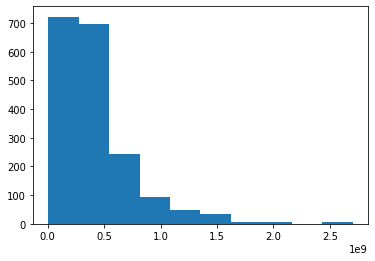

In [13]:
plt.hist(data['Hammer_price'])
plt.show()

In [14]:
lambda_boxcox = boxcox(data['Hammer_price'])[1]
data['Hammer_price'] = boxcox(data['Hammer_price'])[0]

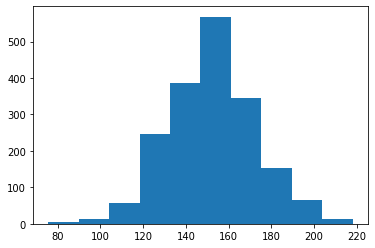

In [15]:
plt.hist(data['Hammer_price'])
plt.show()

In [16]:
# 다시 transformation 이전으로 바꿔주는 함수!!
inv_boxcox(data['Hammer_price'], lambda_boxcox)

0       7.600000e+08
1       9.718900e+08
2       9.340000e+07
3       2.568990e+08
4       1.586600e+08
            ...     
1850    4.025000e+08
1851    4.302346e+08
1852    1.119000e+09
1853    4.030000e+08
1854    6.860100e+08
Name: Hammer_price, Length: 1855, dtype: float64

#### **6) floor -> skyscraper 변수**

In [17]:
dummy = []
for i in range(data.shape[0]):
    dummy.append(max(30,data['Current_floor'][i]))
data['skyscraper'] = dummy

## 마지막으로 떨구고 Y 추가

In [18]:
data = data.drop(['Appraisal_company','addr_do', 'addr_si','Total_floor',
       'Current_floor'],axis=1)

C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\rkdxo\anaconda3\envs\kang\lib\site-packages\matplotlib\backends\back

<AxesSubplot:>

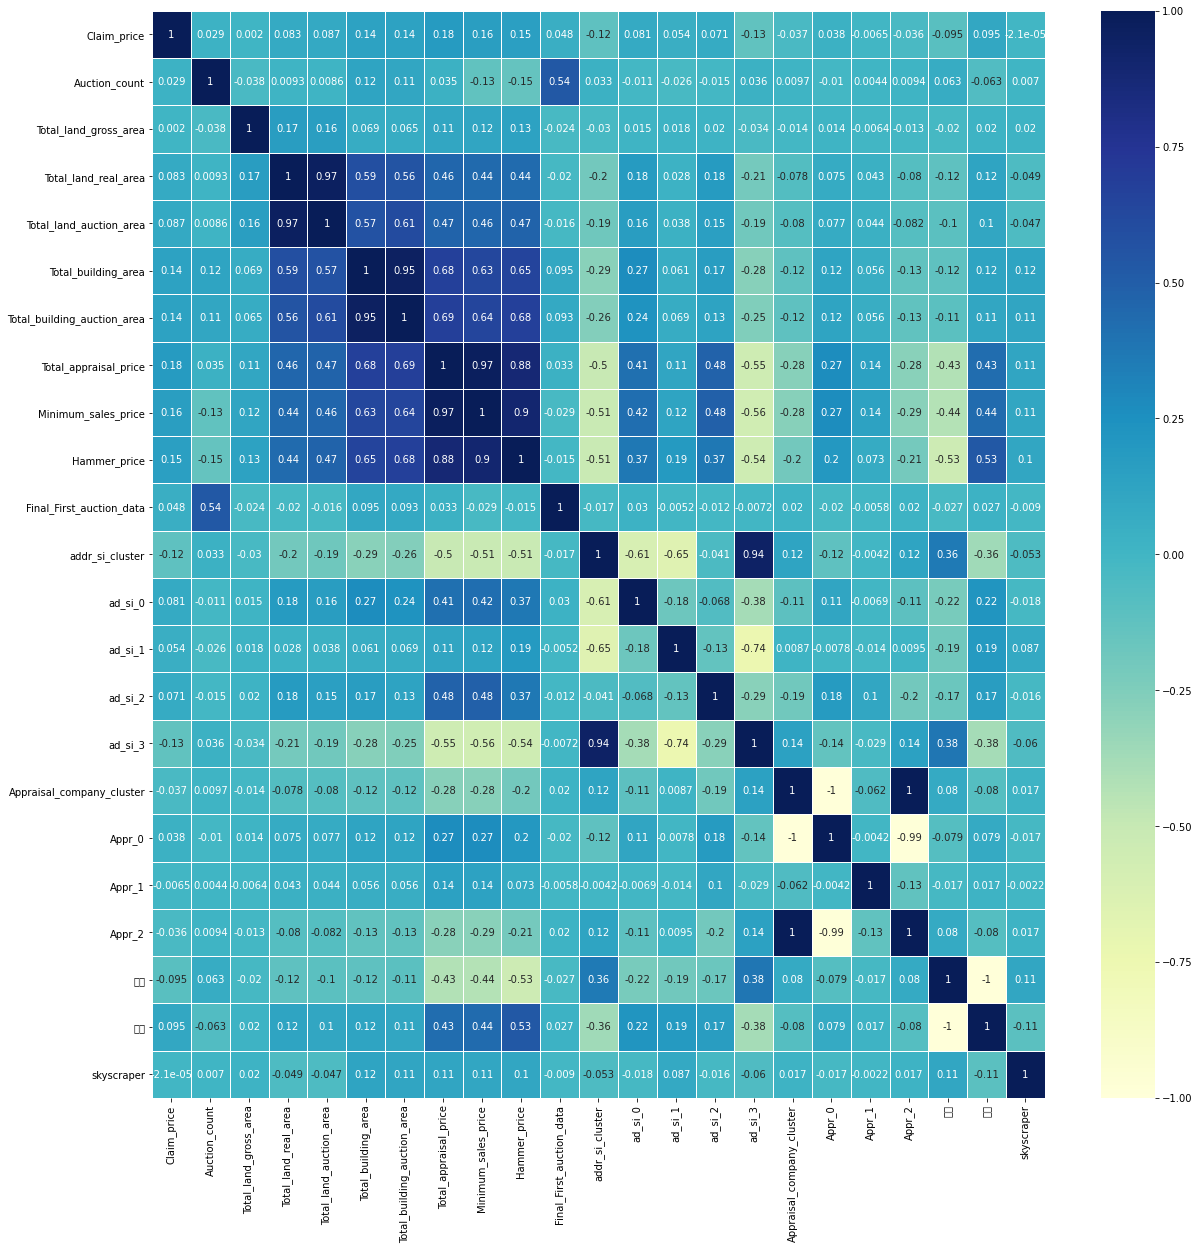

In [19]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,20)
sns.heatmap(data.corr(),linewidths=0.5,annot=True,cmap='YlGnBu')

## PCA

<AxesSubplot:>

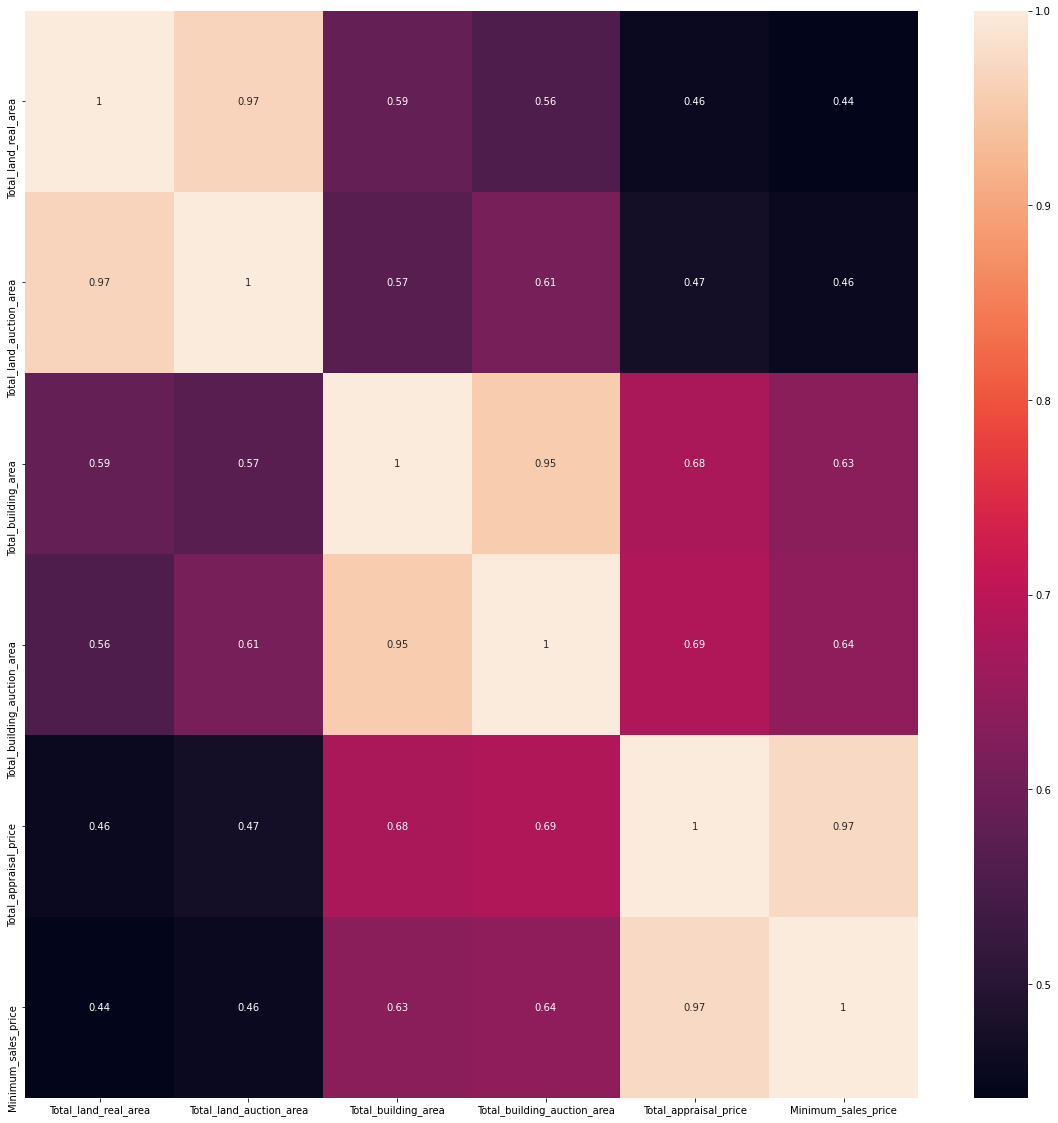

In [20]:
plt.figure(figsize=(20,20))

sns.heatmap(data.iloc[:,3:9].corr(),annot=True)

In [21]:
data.iloc[:,3:9]

,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price
0,37.35,37.35,181.77,181.77,836000000,668800000
1,18.76,18.76,118.38,118.38,1073000000,858400000
2,71.00,71.00,49.94,49.94,119000000,76160000
3,32.98,32.98,84.91,84.91,288400000,230720000
4,45.18,45.18,84.96,84.96,170000000,136000000
...,...,...,...,...,...,...
1850,40.55,40.55,84.87,84.87,401000000,401000000
1851,39.60,39.60,114.81,114.81,454000000,363200000
1852,19.03,19.03,133.98,133.98,1285000000,1028000000
1853,42.20,42.20,84.94,84.94,407000000,325600000


In [22]:
from sklearn.preprocessing import StandardScaler

data_4pca = data.iloc[:,3:9]

data_scaled = pd.DataFrame(StandardScaler().fit_transform(data_4pca), columns=data_4pca.columns, index = data_4pca.index)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(random_state=2016147006)
X_p = pca.fit_transform(data_scaled)

#Eigenvalue 구하기
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors=data_scaled.shape[1], rotation= None)
fa.fit(data_scaled)

ev, v = fa.get_eigenvalues()
ev

array([4.23507607e+00, 1.07251766e+00, 5.88342433e-01, 7.57988036e-02,
       2.54122021e-02, 2.85282679e-03])

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


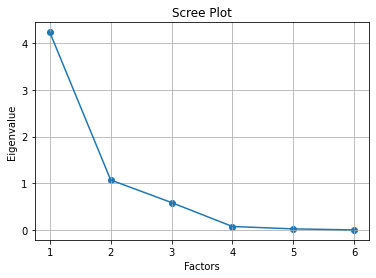

In [24]:
plt.scatter(range(1, data_scaled.shape[1]+1),ev)
plt.plot(range(1,data_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

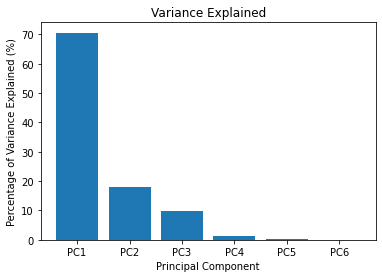

In [25]:
import numpy as np
each_variance_ratio = pca.explained_variance_ratio_

# 누적 분산 설명 비율

cumsum = np.cumsum(pca.explained_variance_ratio_)

pd.Series(np.cumsum(pca.explained_variance_ratio_)) #고유값을 기준으로 설명 가능한 분산 (누적)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained (%)')
plt.xlabel('Principal Component')
plt.title('Variance Explained')
plt.show()

In [26]:
pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)

,PC1,PC2
Total_land_real_area,0.381317,0.388127
Total_land_auction_area,0.563714,0.547767
Total_building_area,-0.214817,-0.200224
Total_building_auction_area,0.451076,-0.455970
Total_appraisal_price,-0.005146,0.016151
Minimum_sales_price,-0.535894,0.548680


<AxesSubplot:>

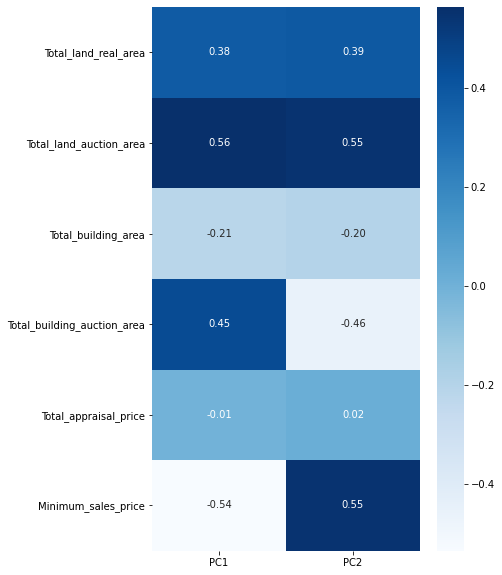

In [27]:
pca_result = pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)
plt.figure(figsize=(6,10))
sns.heatmap(pca_result, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

In [28]:
X_pca = pca.fit_transform(data_scaled)

X_ppca = pd.DataFrame(X_pca[:,:2],columns=['PC1','PC2'],
                      index = data_scaled.index)

X_ppca

,PC1,PC2
0,2.823222,-1.435719
1,1.278944,-2.646606
2,-0.530059,2.631658
3,-0.706458,0.081095
4,-0.533846,0.986816
...,...,...
1850,-0.078348,0.092530
1851,0.563585,-0.107314
1852,2.107911,-3.202834
1853,-0.112361,0.278945


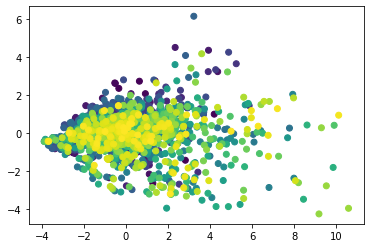

In [29]:
plt.scatter(x=X_ppca['PC1'],y=X_ppca['PC2'], c=X_ppca.index)

## 새롭게 합치기

In [30]:
data = data.drop(['Total_land_real_area', 'Total_land_gross_area',
                  'Total_land_auction_area', 'Total_building_area',
                  'Total_building_auction_area', 'Total_appraisal_price',
                  'addr_si_cluster', 'Appraisal_company_cluster',
                  'Minimum_sales_price', '부산'],axis=1)

In [31]:
data = pd.concat([X_ppca, data],axis=1)

In [32]:
data

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,skyscraper
0,2.823222,-1.435719,1766037301,2,175.394072,35,0,1,0,0,0,0,1,0,30
1,1.278944,-2.646606,152946867,2,182.985785,35,0,1,0,0,0,0,1,0,51
2,-0.530059,2.631658,11326510,3,121.888773,77,0,0,0,1,0,0,1,0,30
3,-0.706458,0.081095,183581724,2,145.387692,105,0,0,0,1,0,0,1,0,30
4,-0.533846,0.986816,45887671,2,133.700341,28,0,0,0,1,0,0,1,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,-0.078348,0.092530,280000000,1,157.155252,0,0,0,0,1,0,0,1,1,30
1851,0.563585,-0.107314,200000000,2,158.977901,28,0,0,0,1,0,0,1,1,30
1852,2.107911,-3.202834,354805459,2,187.479268,28,0,1,0,0,0,0,1,1,30
1853,-0.112361,0.278945,80000000,2,157.189024,35,0,0,0,1,0,0,1,1,30


In [33]:
data.corr()['Hammer_price']

PC1                         0.801433
PC2                        -0.368775
Claim_price                 0.154280
Auction_count              -0.145719
Hammer_price                1.000000
Final_First_auction_data   -0.015411
ad_si_0                     0.369572
ad_si_1                     0.189547
ad_si_2                     0.372834
ad_si_3                    -0.544001
Appr_0                      0.197915
Appr_1                      0.072808
Appr_2                     -0.205866
서울                          0.533870
skyscraper                  0.102719
Name: Hammer_price, dtype: float64

## Linear Regression

In [34]:
from statsmodels.formula.api import ols

In [35]:
res = ols('Hammer_price ~ PC1 + PC2 + Claim_price + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + Appr_0 + Appr_1 + 서울 + skyscraper',
          data = data).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1004.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:18:30   Log-Likelihood:                -6356.4
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1842   BIC:                         1.281e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  138.4719      4.073     34.001      0.000     130.484     146.459
PC1                          7.0462      0.105     66.989      0.000       6.840       7.253
PC2                         -5.4190      0.195    -27.841      0.000      -5.801      -5.037
Claim_price               -1.59e-10    1.6e-10     -0.997      0.319   -4.72e-10    1.54e-10
Auction_count               -3.5842      0.229    -15.655      0.000      -4.033      -3.135
Final_First_auction_data     0.0038      0.001      2.898      0.004       0.001       0.006
ad_si_0                      3.0595      0.763      4.010      0.000       1.563       4.556
ad_si_1                      3.3228      0.441      7.535      0.000       2.458       4.188
ad_si_2                      5.2771      0.956      5.518      0.000       3.401       7.153
Appr_0                      -1.3242      1.029     -1.287      0.198      -3.343       0.694
Appr_1                     -21.1708      7.570     -2.797      0.005     -36.018      -6.324
서울                          10.2006      0.409     24.928      0.000       9.398      11.003
skyscraper                   0.4129      0.132      3.117      0.002       0.153       0.673
==============================================================================
Omnibus:                      554.932   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.534
Skew:                          -1.404   Prob(JB):                         0.00
Kurtosis:                       7.568   Cond. No.                     5.03e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
res2 = ols('Hammer_price ~ PC1 + PC2 + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + Appr_0 + Appr_1 + 서울 + skyscraper',
          data = data).fit()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1095.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:18:30   Log-Likelihood:                -6356.9
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1843   BIC:                         1.280e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  138.3632      4.071     33.986      0.000     130.379     146.348
PC1                          7.0346      0.105     67.292      0.000       6.830       7.240
PC2                         -5.4089      0.194    -27.827      0.000      -5.790      -5.028
Auction_count               -3.5865      0.229    -15.666      0.000      -4.035      -3.137
Final_First_auction_data     0.0038      0.001      2.871      0.004       0.001       0.006
ad_si_0                      3.0427      0.763      3.989      0.000       1.547       4.539
ad_si_1                      3.3059      0.441      7.503      0.000       2.442       4.170
ad_si_2                      5.2602      0.956      5.501      0.000       3.385       7.136
Appr_0                      -1.3189      1.029     -1.281      0.200      -3.337       0.700
Appr_1                     -20.9751      7.568     -2.772      0.006     -35.817      -6.133
서울                          10.1912      0.409     24.912      0.000       9.389      10.994
skyscraper                   0.4154      0.132      3.137      0.002       0.156       0.675
==============================================================================
Omnibus:                      555.406   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.982
Skew:                          -1.406   Prob(JB):                         0.00
Kurtosis:                       7.567   Cond. No.                     7.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
res3 = ols('Hammer_price ~ PC1 + PC2 + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + 서울 + skyscraper',
          data = data).fit()

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1332.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:18:30   Log-Likelihood:                -6361.5
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1845   BIC:                         1.280e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  137.7325      4.070     33.842      0.000     129.750     145.715
PC1                          6.9914      0.103     67.573      0.000       6.788       7.194
PC2                         -5.3327      0.192    -27.715      0.000      -5.710      -4.955
Auction_count               -3.5937      0.229    -15.668      0.000      -4.044      -3.144
Final_First_auction_data     0.0039      0.001      2.942      0.003       0.001       0.006
ad_si_0                      3.1037      0.762      4.071      0.000       1.608       4.599
ad_si_1                      3.3343      0.441      7.555      0.000       2.469       4.200
ad_si_2                      5.0524      0.953      5.303      0.000       3.184       6.921
서울                          10.2332      0.410     24.985      0.000       9.430      11.036
skyscraper                   0.4339      0.132      3.276      0.001       0.174       0.694
==============================================================================
Omnibus:                      551.890   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2194.362
Skew:                          -1.398   Prob(JB):                         0.00
Kurtosis:                       7.535   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Test set 전처리 시작

In [38]:
testdata = pd.read_csv("Auction_master_test.csv")

In [39]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',10000)

In [40]:
from datetime import datetime
testdata['First_auction_date'] = testdata['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
testdata['Final_auction_date'] = testdata['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

testdata['Final_First_auction_data'] = testdata['Final_auction_date']-testdata['First_auction_date'] #최종경매일, 최초경매일 일수 차이
testdata['Final_First_auction_data'] = testdata['Final_First_auction_data'].astype('timedelta64[D]').astype(int)

In [41]:
testdata = testdata.drop(['Auction_key','Auction_class', 'Bid_class','Appraisal_date','Auction_miscarriage_count',
                  'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor','addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date','Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x'],axis=1)

In [42]:
testdata.shape

(829, 16)

In [43]:
testdata.head()

,Claim_price,Appraisal_company,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_do,addr_si,Total_floor,Current_floor,Hammer_price,Final_First_auction_data
0,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,244565981,100174000,부산,동래구,15,5,0,1058
1,1087000000,대한감정,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,부산,동래구,15,6,0,1030
2,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,8,0,1058
3,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,9,0,1058
4,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,11,0,1058


### trainset에 없었던 감정사들 총 9행 ==> 분석에 큰 영향을 끼치지 않을 것 같아 삭제

In [44]:
test1 = testdata[testdata['Appraisal_company']=='정인제감정']
test2 = testdata[testdata['Appraisal_company']=='밝은숲감정']
test3 = testdata[testdata['Appraisal_company']=='우감정']
test4 = testdata[testdata['Appraisal_company']=='성우감정']
test5 = testdata[testdata['Appraisal_company']=='청림감정']
test6 = testdata[testdata['Appraisal_company']=='새날감정']
test7 = testdata[testdata['Appraisal_company']=='아람감정']
test8 = testdata[testdata['Appraisal_company']=='LH감정']
test9 = testdata[testdata['Appraisal_company']=='씨티감정']
testno = pd.concat([test1,test2,test3,test4,test5,test6,test7,test8,test9],axis = 0) 

In [45]:
testno

,Claim_price,Appraisal_company,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_do,addr_si,Total_floor,Current_floor,Hammer_price,Final_First_auction_data
172,323557320,정인제감정,2,12685.8,49.61,49.61,121.33,121.33,582000000,465600000,부산,연제구,23,2,0,35
285,150000000,정인제감정,2,14788.0,34.30,34.30,84.78,84.78,385000000,308000000,부산,북구,25,22,0,35
336,295000000,밝은숲감정,5,7831.9,38.35,38.35,84.95,84.95,740000000,378880000,서울,강남구,11,4,0,196
404,800000000,성우감정,2,99436.4,43.54,43.54,80.35,80.35,679000000,543200000,서울,송파구,12,8,0,35
493,51480000,청림감정,4,41403.1,47.81,47.81,84.59,84.59,420000000,215040000,서울,은평구,15,1,0,105
576,384455200,새날감정,3,1145.0,98.20,98.20,163.40,163.40,436000000,279040000,서울,구로구,5,5,0,378
654,79200000,아람감정,3,74.0,14.87,14.87,40.83,40.83,127000000,101600000,서울,구로구,5,5,0,132
791,186336732,LH감정,1,4824.1,45.25,45.25,84.99,84.99,398000000,398000000,서울,동대문구,14,9,0,0
802,200000000,씨티감정,1,677.0,37.37,37.37,79.21,79.21,250000000,250000000,서울,강북구,7,6,0,0


### 클러스터링 넘버 붙이기(구, 시, 감정사 순)

In [46]:
testdata['ad_si_0'] = 0

In [47]:
testdata.head()

,Claim_price,Appraisal_company,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_do,addr_si,Total_floor,Current_floor,Hammer_price,Final_First_auction_data,ad_si_0
0,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,244565981,100174000,부산,동래구,15,5,0,1058,0
1,1087000000,대한감정,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,부산,동래구,15,6,0,1030,0
2,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,8,0,1058,0
3,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,9,0,1058,0
4,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,11,0,1058,0


In [48]:
for i in range(829):
    if testdata['addr_si'][i] == '서초구':
        testdata['ad_si_0'][i] = 1
    elif testdata['addr_si'][i] == '용산구':
        testdata['ad_si_0'][i] = 1
    elif testdata['addr_si'][i] == '송파구':
        testdata['ad_si_0'][i] = 1
    else:
        testdata['ad_si_0'][i] = 0

<ipython-input-48-8960670d8615>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_0'][i] = 0
<ipython-input-48-8960670d8615>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_0'][i] = 1
<ipython-input-48-8960670d8615>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_0'][i] = 1
<ipython-input-48-8960670d8615>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [49]:
testdata['ad_si_1']=0

In [50]:
for i in range(829):
    if testdata['addr_si'][i] == '해운대구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '중구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '영등포구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '양천구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '마포구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '성동구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '광진구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '동대문구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '강동구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '동작구':
        testdata['ad_si_1'][i] = 1
    elif testdata['addr_si'][i] == '종로구':
        testdata['ad_si_1'][i] = 1
    else:
        testdata['ad_si_1'][i] = 0

<ipython-input-50-baae4d179d70>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_1'][i] = 0
<ipython-input-50-baae4d179d70>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_1'][i] = 1
<ipython-input-50-baae4d179d70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_1'][i] = 1
<ipython-input-50-baae4d179d70>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [51]:
testdata['ad_si_2'] = 0

In [52]:
for i in range(829):
    if testdata['addr_si'][i] == '강남구':
        testdata['ad_si_2'][i] = 1

<ipython-input-52-3b1e0d13740c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['ad_si_2'][i] = 1


In [53]:
testdata['서울'] = 0

In [54]:
for i in range(829):
    if testdata['addr_do'][i] == '서울':
        testdata['서울'][i] = 1

<ipython-input-54-a0af744cf8d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['서울'][i] = 1


In [55]:
testdata.head()

,Claim_price,Appraisal_company,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_do,addr_si,Total_floor,Current_floor,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,서울
0,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,244565981,100174000,부산,동래구,15,5,0,1058,0,0,0,0
1,1087000000,대한감정,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,부산,동래구,15,6,0,1030,0,0,0,0
2,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,8,0,1058,0,0,0,0
3,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,9,0,1058,0,0,0,0
4,1087000000,대한감정,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,부산,동래구,15,11,0,1058,0,0,0,0


In [56]:
dataa1.head()

NameError: name 'dataa1' is not defined

In [73]:
dataa1['Appraisal_company'].unique()

KeyError: 'Appraisal_company'

In [ ]:
dataa2 = data[data['Appr_1'] == 1]

In [70]:
dataa2['Appraisal_company'].unique()

NameError: name 'dataa2' is not defined

In [57]:
testdata['Appr_0'] = 0

In [58]:
for i in range(829):
    if testdata['Appraisal_company'][i] == '중앙감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '현대기업감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '건감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '더존감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '이산감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == 'AYR감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '석률감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '정평감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == 'S.R감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '서현감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '율산감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '상감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '경일감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '서울감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '한국기업가치감정':
        testdata['Appr_0'][i] = 1
    elif testdata['Appraisal_company'][i] == '정용규감정':
        testdata['Appr_0'][i] = 1
    else:
        testdata['Appr_0'][i] = 0

<ipython-input-58-c41afb5f505b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['Appr_0'][i] = 0
<ipython-input-58-c41afb5f505b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['Appr_0'][i] = 1
<ipython-input-58-c41afb5f505b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['Appr_0'][i] = 1
<ipython-input-58-c41afb5f505b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [59]:
testdata['Appr_1'] = 0

In [60]:
for i in range(829):
    if testdata['Appraisal_company'][i] == '유림감정':
        testdata['Appr_1'][i] = 1

<ipython-input-60-0be017e2f1ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['Appr_1'][i] = 1


### trainset에 없는 감정사 삭제

In [61]:
test1 = testdata[testdata['Appraisal_company']=='정인제감정']
test2 = testdata[testdata['Appraisal_company']=='밝은숲감정']
test3 = testdata[testdata['Appraisal_company']=='우감정']
test4 = testdata[testdata['Appraisal_company']=='성우감정']
test5 = testdata[testdata['Appraisal_company']=='청림감정']
test6 = testdata[testdata['Appraisal_company']=='새날감정']
test7 = testdata[testdata['Appraisal_company']=='아람감정']
test8 = testdata[testdata['Appraisal_company']=='LH감정']
test9 = testdata[testdata['Appraisal_company']=='씨티감정']
testno = pd.concat([test1,test2,test3,test4,test5,test6,test7,test8,test9],axis = 0) 

In [62]:
testno

,Claim_price,Appraisal_company,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,addr_do,addr_si,Total_floor,Current_floor,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,서울,Appr_0,Appr_1
172,323557320,정인제감정,2,12685.8,49.61,49.61,121.33,121.33,582000000,465600000,부산,연제구,23,2,0,35,0,0,0,0,0,0
285,150000000,정인제감정,2,14788.0,34.30,34.30,84.78,84.78,385000000,308000000,부산,북구,25,22,0,35,0,0,0,0,0,0
336,295000000,밝은숲감정,5,7831.9,38.35,38.35,84.95,84.95,740000000,378880000,서울,강남구,11,4,0,196,0,0,1,1,0,0
404,800000000,성우감정,2,99436.4,43.54,43.54,80.35,80.35,679000000,543200000,서울,송파구,12,8,0,35,1,0,0,1,0,0
493,51480000,청림감정,4,41403.1,47.81,47.81,84.59,84.59,420000000,215040000,서울,은평구,15,1,0,105,0,0,0,1,0,0
576,384455200,새날감정,3,1145.0,98.20,98.20,163.40,163.40,436000000,279040000,서울,구로구,5,5,0,378,0,0,0,1,0,0
654,79200000,아람감정,3,74.0,14.87,14.87,40.83,40.83,127000000,101600000,서울,구로구,5,5,0,132,0,0,0,1,0,0
791,186336732,LH감정,1,4824.1,45.25,45.25,84.99,84.99,398000000,398000000,서울,동대문구,14,9,0,0,0,1,0,1,0,0
802,200000000,씨티감정,1,677.0,37.37,37.37,79.21,79.21,250000000,250000000,서울,강북구,7,6,0,0,0,0,0,1,0,0


In [63]:
testdata1 = testdata.drop([172,285,336,404,493,576,654,791,802])

In [64]:
testdata1 = testdata1.reset_index(drop=True)

In [65]:
testdata1 = testdata1.drop(['Appraisal_company','addr_do', 'addr_si'],axis=1)

### skyscraper 생성

In [66]:
dummy = []
for i in range(testdata1.shape[0]):
    dummy.append(max(30,testdata1['Current_floor'][i]))
testdata1['skyscraper'] = dummy

In [67]:
testdata1.shape

(820, 20)

In [68]:
testdata1 = testdata1.drop(['Total_floor','Current_floor'],axis=1)

In [69]:
testdata1.head()

,Claim_price,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,서울,Appr_0,Appr_1,skyscraper
0,1087000000,7,532.0,18.22,18.22,107.28,107.28,244565981,100174000,0,1058,0,0,0,0,0,0,30
1,1087000000,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,0,1030,0,0,0,0,0,0,30
2,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30
3,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30
4,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30


### PCA

In [70]:
ptest = testdata1.iloc[:,3:9]
ptest

,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price
0,18.22,18.22,107.28,107.28,244565981,100174000
1,16.65,16.65,98.08,98.08,228745632,117118000
2,18.22,18.22,107.28,107.28,249565981,102222000
3,18.22,18.22,107.28,107.28,249565981,102222000
4,18.22,18.22,107.28,107.28,249565981,102222000
5,18.22,18.22,107.28,107.28,249565981,102222000
6,16.65,16.65,98.08,98.08,228745632,117118000
7,63.42,63.42,108.81,108.81,213000000,170400000
8,18.07,18.07,59.70,59.70,209000000,167200000
9,59.64,59.64,138.56,138.56,326000000,260800000


In [71]:
ptests = pd.DataFrame(StandardScaler().fit_transform(ptest), columns=ptest.columns, index = ptest.index)

In [72]:
matp = pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)
matp

,PC1,PC2
Total_land_real_area,0.381317,0.388127
Total_land_auction_area,0.563714,0.547767
Total_building_area,-0.214817,-0.200224
Total_building_auction_area,0.451076,-0.455970
Total_appraisal_price,-0.005146,0.016151
Minimum_sales_price,-0.535894,0.548680


In [73]:
ptests['a'] = 0.388127
ptests['b'] = 0.547767
ptests['c'] = -0.200224
ptests['d'] = -0.45597
ptests['e'] = 0.016151
ptests['f'] = 0.54868

In [74]:
ptests.head()

,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,a,b,c,d,e,f
0,-0.085810,-0.956655,0.369868,0.404579,-0.537927,-0.836122,0.388127,0.547767,-0.200224,-0.45597,0.016151,0.54868
1,-0.089573,-1.029961,0.136578,0.176518,-0.575814,-0.788908,0.388127,0.547767,-0.200224,-0.45597,0.016151,0.54868
2,-0.085810,-0.956655,0.369868,0.404579,-0.525953,-0.830415,0.388127,0.547767,-0.200224,-0.45597,0.016151,0.54868
3,-0.085810,-0.956655,0.369868,0.404579,-0.525953,-0.830415,0.388127,0.547767,-0.200224,-0.45597,0.016151,0.54868
4,-0.085810,-0.956655,0.369868,0.404579,-0.525953,-0.830415,0.388127,0.547767,-0.200224,-0.45597,0.016151,0.54868


In [75]:
PC11 = []
for i in range(820):
    PC11.append(ptests['Total_land_real_area'][i]*ptests['a'][i])

In [76]:
PC22 = []
for i in range(820):
    PC22.append(ptests['Total_land_auction_area'][i]*ptests['b'][i])

In [77]:
PC33 = []
for i in range(820):
    PC33.append(ptests['Total_building_area'][i]*ptests['c'][i])

In [78]:
PC44 = []
for i in range(820):
    PC44.append(ptests['Total_building_auction_area'][i]*ptests['d'][i])

In [79]:
PC55 = []
for i in range(820):
    PC55.append(ptests['Total_appraisal_price'][i]*ptests['e'][i])

In [80]:
PC66 = []
for i in range(820):
    PC66.append(ptests['Minimum_sales_price'][i]*ptests['f'][i])

In [81]:
PC2 = []
for i in range(820):
    PC2.append(PC11[i]+PC22[i]+PC33[i]+PC44[i]+PC55[i]+PC66[i])

In [82]:
testdata1['PC2'] = PC2

In [83]:
ptests['a'] = 0.381317
ptests['b'] = 0.563714
ptests['c'] = -0.214817
ptests['d'] = 0.451076
ptests['e'] = -0.005146
ptests['f'] = -0.535894

In [84]:
PC11 = []
for i in range(820):
    PC11.append(ptests['Total_land_real_area'][i]*ptests['a'][i])

In [85]:
PC22 = []
for i in range(820):
    PC22.append(ptests['Total_land_auction_area'][i]*ptests['b'][i])

In [86]:
PC33 = []
for i in range(820):
    PC33.append(ptests['Total_building_area'][i]*ptests['c'][i])

In [87]:
PC44 = []
for i in range(820):
    PC44.append(ptests['Total_building_auction_area'][i]*ptests['d'][i])

In [88]:
PC55 = []
for i in range(820):
    PC55.append(ptests['Total_appraisal_price'][i]*ptests['e'][i])

In [89]:
PC66 = []
for i in range(820):
    PC66.append(ptests['Minimum_sales_price'][i]*ptests['f'][i])

In [90]:
PC1 = []
for i in range(820):
    PC1.append(PC11[i]+PC22[i]+PC33[i]+PC44[i]+PC55[i]+PC66[i])

In [91]:
testdata1['PC1'] = PC1

In [92]:
testdata1

,Claim_price,Auction_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,서울,Appr_0,Appr_1,skyscraper,PC2,PC1
0,1087000000,7,532.0,18.22,18.22,107.28,107.28,244565981,100174000,0,1058,0,0,0,0,0,0,30,-1.283313,-0.018118
1,1087000000,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,0,1030,0,0,0,0,0,0,30,-1.148936,-0.138741
2,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30,-1.279988,-0.021238
3,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30,-1.279988,-0.021238
4,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30,-1.279988,-0.021238
5,1087000000,7,532.0,18.22,18.22,107.28,107.28,249565981,102222000,0,1058,0,0,0,0,0,0,30,-1.279988,-0.021238
6,1087000000,6,532.0,16.65,16.65,98.08,98.08,228745632,117118000,0,1030,0,0,0,0,0,0,30,-1.148936,-0.138741
7,120000000,3,3906.0,63.42,63.42,108.81,108.81,213000000,170400000,0,63,0,0,0,0,0,0,30,-0.004141,1.117187
8,24896567,2,23691.9,18.07,18.07,59.70,59.70,209000000,167200000,0,28,0,0,0,0,0,0,30,-0.406814,-0.394702
9,8329677,2,125210.8,59.64,59.64,138.56,138.56,326000000,260800000,0,63,0,0,0,0,0,0,30,-0.449070,1.048462


In [93]:
testdata1 = testdata1.drop(['Total_land_real_area', 'Total_land_gross_area',
                  'Total_land_auction_area', 'Total_building_area',
                  'Total_building_auction_area', 'Total_appraisal_price',
                 'Minimum_sales_price'],axis=1)

In [94]:
testdata1 = testdata1[['PC1','PC2','Claim_price','Auction_count','Hammer_price','Final_First_auction_data','ad_si_0','ad_si_1','ad_si_2','Appr_0','Appr_1','서울','skyscraper']]

In [116]:
csv.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,transformed_Hammer_price,skyscraper
0,2.823222,-1.435719,1766037301,2,760000000,35,0,1,0,0,0,0,1,0,175.394072,30
1,1.278944,-2.646606,152946867,2,971889999,35,0,1,0,0,0,0,1,0,182.985785,51
2,-0.530059,2.631658,11326510,3,93399999,77,0,0,0,1,0,0,1,0,121.888773,30
3,-0.706458,0.081095,183581724,2,256899000,105,0,0,0,1,0,0,1,0,145.387692,30
4,-0.533846,0.986816,45887671,2,158660000,28,0,0,0,1,0,0,1,0,133.700341,30


In [95]:
testdata123 = testdata1.drop(['Claim_price','Appr_0','Appr_1'],axis=1)

In [96]:
testdata123

,PC1,PC2,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,서울,skyscraper
0,-0.018118,-1.283313,7,0,1058,0,0,0,0,30
1,-0.138741,-1.148936,6,0,1030,0,0,0,0,30
2,-0.021238,-1.279988,7,0,1058,0,0,0,0,30
3,-0.021238,-1.279988,7,0,1058,0,0,0,0,30
4,-0.021238,-1.279988,7,0,1058,0,0,0,0,30
5,-0.021238,-1.279988,7,0,1058,0,0,0,0,30
6,-0.138741,-1.148936,6,0,1030,0,0,0,0,30
7,1.117187,-0.004141,3,0,63,0,0,0,0,30
8,-0.394702,-0.406814,2,0,28,0,0,0,0,30
9,1.048462,-0.449070,2,0,63,0,0,0,0,30


In [97]:
res3 = ols('Hammer_price ~ PC1 + PC2 + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + 서울 + skyscraper',
          data = data).fit()

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1332.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:20:00   Log-Likelihood:                -6361.5
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1845   BIC:                         1.280e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  137.7325      4.070     33.842      0.000     129.750     145.715
PC1                          6.9914      0.103     67.573      0.000       6.788       7.194
PC2                         -5.3327      0.192    -27.715      0.000      -5.710      -4.955
Auction_count               -3.5937      0.229    -15.668      0.000      -4.044      -3.144
Final_First_auction_data     0.0039      0.001      2.942      0.003       0.001       0.006
ad_si_0                      3.1037      0.762      4.071      0.000       1.608       4.599
ad_si_1                      3.3343      0.441      7.555      0.000       2.469       4.200
ad_si_2                      5.0524      0.953      5.303      0.000       3.184       6.921
서울                          10.2332      0.410     24.985      0.000       9.430      11.036
skyscraper                   0.4339      0.132      3.276      0.001       0.174       0.694
==============================================================================
Omnibus:                      551.890   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2194.362
Skew:                          -1.398   Prob(JB):                         0.00
Kurtosis:                       7.535   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
hammer = res3.predict(testdata123)

In [99]:
hammer

0      136.406777
1      138.332108
2      136.367237
3      136.367237
4      136.367237
5      136.367237
6      138.332108
7      148.043736
8      143.078994
9      153.529644
10     147.297338
11     136.448884
12     143.415377
13     141.629638
14     151.561296
15     144.394919
16     152.671807
17     137.997274
18     144.019605
19     143.676905
20     128.804687
21     152.716798
22     141.981275
23     142.043157
24     141.476901
25     144.316162
26     146.222117
27     156.566667
28     143.945328
29     153.552340
30     147.933608
31     145.995192
32     151.221235
33     145.202168
34     148.057522
35     145.022439
36     143.215698
37     147.209258
38     146.792541
39     146.997031
40     143.374829
41     146.451246
42     155.806051
43     148.705602
44     153.364134
45     147.047680
46     145.072480
47     154.186901
48     149.422058
49     143.280420
50     149.831670
51     146.980230
52     149.034185
53     151.755403
54     140.571990
55     146

In [100]:
prehammer = inv_boxcox(hammer, lambda_boxcox)

In [103]:
prehammer

0     178012877.47702
1     192945462.08392
2     177716613.52416
3     177716613.52416
4     177716613.52416
5     177716613.52416
6     192945462.08392
7     285147428.90337
8     234277141.51583
9     351743261.03885
10    276959805.37031
11    178328822.96596
12    237465863.03868
13    220943016.85981
14    326501022.65293
15    246958070.06519
16    340549540.07861
17    190276129.09814
18    243284432.63776
19    239969909.62899
20    128097537.79515
21    341129149.92646
22    224118469.35870
23    224681215.14849
24    219575452.69726
25    246183369.48743
26    265510192.34122
27    393868651.52155
28    242562822.21652
29    352043526.26635
30    283926852.18374
31    263144891.12110
32    322296966.96041
33    255016387.02243
34    285300532.76033
35    253203561.17901
36    235568684.53256
37    276006675.26738
38    271534242.87612
39    273721325.28321
40    237079583.83086
41    267916420.76540
42    382943491.22188
43    292575559.34992
44    349560020.47613
45    2742

In [102]:
pd.options.display.float_format = '{:.5f}'.format

In [104]:
result = pd.read_csv("result.csv")

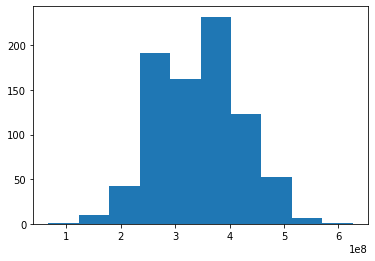

In [105]:
plt.hist(prehammer)
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error

In [108]:
testdata1['transformed_Hammer_price'] = hammer

In [109]:
testdata1.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper,transformed_Hammer_price
0,-0.01812,-1.28331,1087000000,7,0,1058,0,0,0,0,0,0,30,136.40678
1,-0.13874,-1.14894,1087000000,6,0,1030,0,0,0,0,0,0,30,138.33211
2,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
3,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
4,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724


In [110]:
testdata1.to_csv('final_test1.csv', index=False, encoding='cp949')